In [1]:
import kagglehub
import torch
from torch import nn, optim
from torch.nn import functional

In [2]:
# Text8 is a clean dataset, it consist of a text of space separated words
# in lowercase, no punctuation.
text8_path = kagglehub.dataset_download("gupta24789/text8-word-embedding")

with open(f"{text8_path}/text8", 'r') as file:
    text8_raw = file.read()

100%|██████████| 209M/209M [00:02<00:00, 74.8MB/s]

Extracting files...


In [71]:
word_idx: dict[str, int] = {}
word_start = 1
word_count = 0

LIMIT = 5000

for i in range(1, len(text8_raw[:LIMIT])):
    if text8_raw[i] == " ":
        word = text8_raw[word_start: i]
        if not word_idx.get(word, None):
            word_idx[word] = word_count
            word_count += 1
        word_start = i + 1

In [72]:
print(len(word_idx))

378


In [91]:
context_window = 5
embeddings_dim = 300

epochs = 20
learning_rate = 0.001
batch_size = 1024

In [92]:
# Generator of training data
from typing import Generator
import collections

def get_batch(dataset: str, word_idx: dict[str, int], batch_size: int, context_window: int) -> Generator[list[tuple[int, int]], None, None]:
    current_context = collections.deque([], context_window)
    word_start = 1
    batch = []
    for i in range(1, len(dataset)):
        if dataset[i] == " ":
            current_context.append(word_idx[dataset[word_start:i]])
            word_start = i + 1

            if len(current_context) == context_window:
                context_list = list(current_context)
                context = context_list[:(context_window // 2)] + context_list[context_window // 2 + 1:]

                batch.append((context_list[context_window // 2], context))
                if len(batch) == batch_size:
                    yield batch
                    batch = []


for i, batch in enumerate(get_batch(dataset=text8_raw, word_idx=word_idx, batch_size=2, context_window=3)):
    print(batch)
    if i == 5:
        break

[(1, [52, 2]), (2, [1, 3])]
[(3, [2, 4]), (4, [3, 5])]
[(5, [4, 6]), (6, [5, 7])]
[(7, [6, 8]), (8, [7, 9])]
[(9, [8, 10]), (10, [9, 11])]
[(11, [10, 12]), (12, [11, 13])]


In [93]:
# Model definition
class SkipGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size, hidden_layer=128):
        super(SkipGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, (context_size - 1) * vocab_size)
        self.vocab_size = vocab_size
        self.context_size = context_size


    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = self.linear(embeds).view(-1, (self.context_size - 1), self.vocab_size)
        log_probs = functional.log_softmax(out, dim=2)
        return log_probs

In [94]:
# Initialization
model = SkipGramLanguageModeler(len(word_idx), embeddings_dim, context_window)
optimizer = optim.SGD(model.parameters(), lr=0.01)


# Training
for epoch in range(epochs):
  for batch in get_batch(dataset=text8_raw[:LIMIT], word_idx=word_idx, batch_size=min(batch_size, len(word_idx) - context_window // 2 + 1), context_window=context_window):
    total_loss = 0
    for word, context in batch:
      word_index = torch.tensor([word], dtype=torch.long)

      model.zero_grad()
      log_probs = model(word_index).squeeze(0)

      loss = functional.cross_entropy(log_probs, torch.tensor(context, dtype=torch.long))

      loss.backward()
      optimizer.step()

      total_loss += loss

    total_loss /= batch_size
    print(total_loss)
    total_loss = 0

tensor(2.2235, grad_fn=<DivBackward0>)
tensor(2.1995, grad_fn=<DivBackward0>)
tensor(1.9219, grad_fn=<DivBackward0>)
tensor(1.8987, grad_fn=<DivBackward0>)
tensor(1.6612, grad_fn=<DivBackward0>)
tensor(1.6341, grad_fn=<DivBackward0>)
tensor(1.4347, grad_fn=<DivBackward0>)
tensor(1.4072, grad_fn=<DivBackward0>)
tensor(1.2401, grad_fn=<DivBackward0>)
tensor(1.2154, grad_fn=<DivBackward0>)
tensor(1.0758, grad_fn=<DivBackward0>)
tensor(1.0552, grad_fn=<DivBackward0>)
tensor(0.9413, grad_fn=<DivBackward0>)
tensor(0.9245, grad_fn=<DivBackward0>)
tensor(0.8355, grad_fn=<DivBackward0>)
tensor(0.8217, grad_fn=<DivBackward0>)
tensor(0.7557, grad_fn=<DivBackward0>)
tensor(0.7441, grad_fn=<DivBackward0>)
tensor(0.6975, grad_fn=<DivBackward0>)
tensor(0.6875, grad_fn=<DivBackward0>)
tensor(0.6555, grad_fn=<DivBackward0>)
tensor(0.6470, grad_fn=<DivBackward0>)
tensor(0.6252, grad_fn=<DivBackward0>)
tensor(0.6181, grad_fn=<DivBackward0>)
tensor(0.6029, grad_fn=<DivBackward0>)
tensor(0.5972, grad_fn=<D

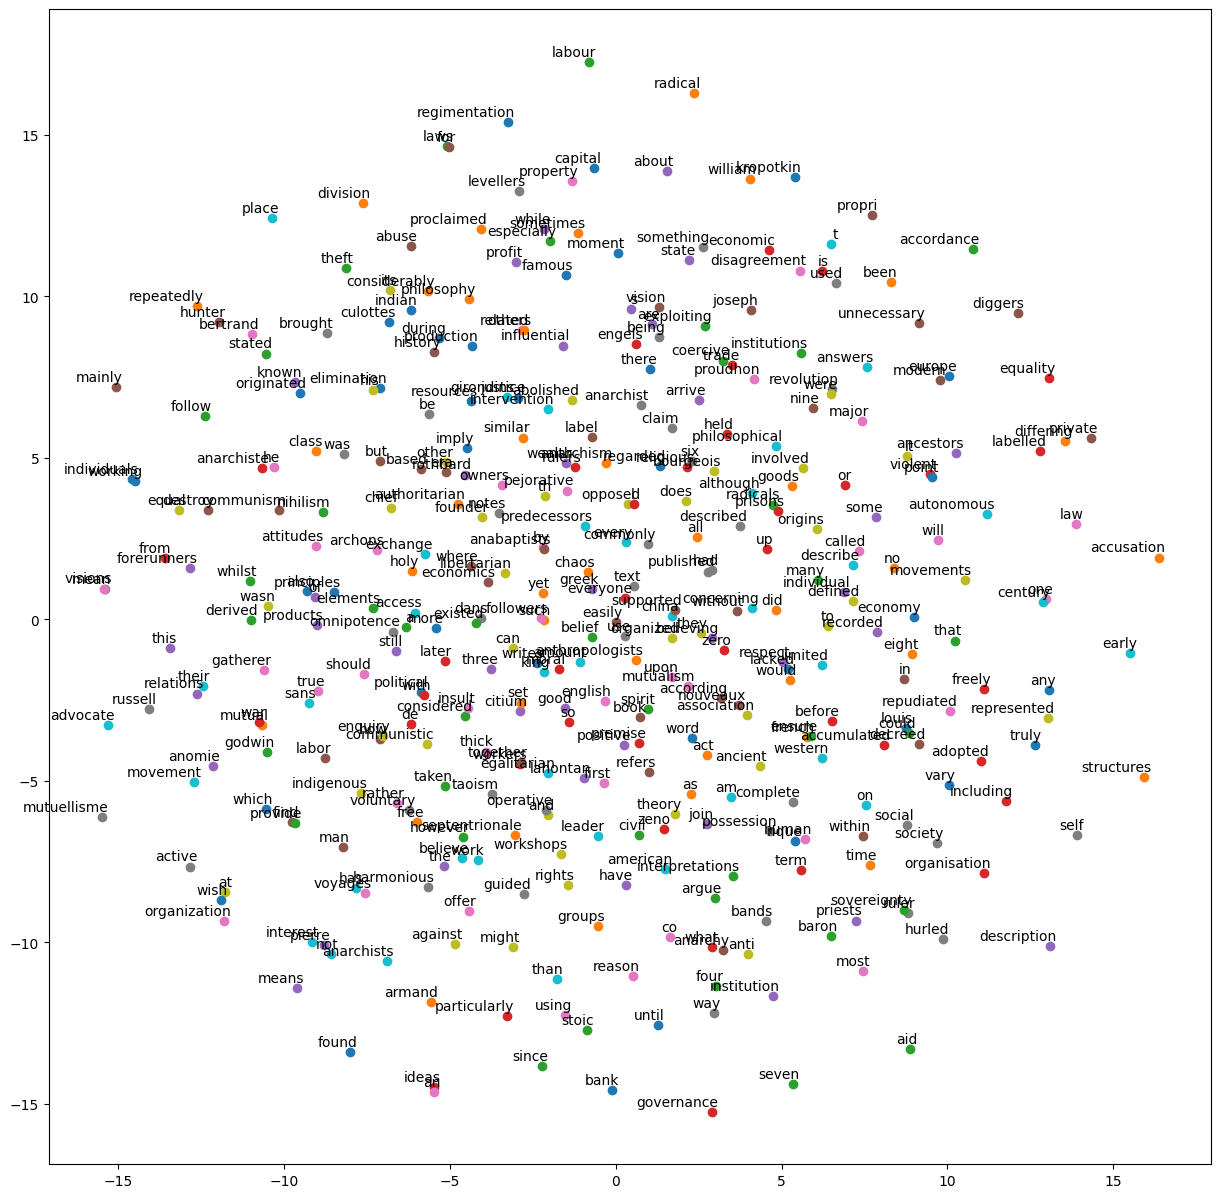

In [95]:
from sklearn.manifold import TSNE
from matplotlib import pylab

num_points = min(400, len(word_idx))

ind2word = {v: k for k, v in word_idx.items()}

embeddings = torch.stack([model.embeddings(torch.tensor([i], dtype=torch.long)) for i in range(0, num_points)]).squeeze(1).detach().numpy()
words = [ind2word[i] for i in range(1, num_points+1)]

tsne = TSNE(perplexity=30, n_components=2, init='pca', max_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(embeddings)

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

plot(two_d_embeddings, words)